In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

Adapted from: https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

### Read Data

In [3]:
data = pd.read_pickle("../Data/GSE115978-allData.pkl")

In [4]:
data

,cellID,cellType,C9orf152,RPS11,ELMO2,CREB3L1,PNMA1,MMP2,TMEM216,TRAF3IP2-AS1,...,MIR4691,GPLD1,RAB8A,RXFP2,PCIF1,PIK3IP1,SNRPD2,SLC39A6,CTSC,AQP7
0,GSM3197115,Mal,0.0,2.067933,1.517847,0.0,1.686722,1.168448,1.526162,0.493304,...,0.000000,0.367588,1.496530,0.0,0.000000,0.966075,1.876721,1.638426,1.512449,0.0
1,GSM3197116,Mal,0.0,1.922102,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.802701,1.909713,0.000000,0.000000,0.000000,0.0
2,GSM3197117,Mal,0.0,2.015497,0.841959,0.0,0.695306,0.000000,0.000000,1.446632,...,0.000000,1.127459,0.000000,0.0,0.000000,0.000000,1.882266,1.141858,1.459023,0.0
3,GSM3197118,Mal,0.0,1.930309,1.691069,0.0,1.592092,0.000000,0.000000,1.038573,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.947145,1.666798,1.047136,0.0
4,GSM3197119,Mal,0.0,2.058619,1.509809,0.0,1.748345,1.676507,1.527963,0.757932,...,0.000000,0.624097,1.686261,0.0,1.601311,1.379246,1.924609,1.715210,1.352315,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7181,GSM3204296,T.CD8,0.0,1.924485,0.000000,0.0,0.000000,0.000000,0.000000,0.917210,...,0.000000,0.617210,1.937055,0.0,0.000000,0.000000,1.986266,0.000000,1.991558,0.0
7182,GSM3204297,T.CD8,0.0,1.977320,0.000000,0.0,0.000000,0.000000,0.000000,1.606071,...,0.000000,0.636619,0.000000,0.0,1.941190,1.212302,0.000000,0.000000,1.324604,0.0
7183,GSM3204298,T.CD8,0.0,1.986248,0.000000,0.0,0.000000,0.000000,0.000000,1.255850,...,0.000000,0.868394,0.000000,0.0,1.997277,0.000000,0.000000,0.000000,1.601028,0.0
7184,GSM3204299,T.CD8,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.398943,...,1.868568,1.488624,0.000000,0.0,0.000000,0.000000,1.668218,0.000000,1.948110,0.0


### Class Distribution

[Text(0, 0, 'Mal'),
 Text(1, 0, 'Macrophage'),
 Text(2, 0, 'Undetermined'),
 Text(3, 0, 'Endo.'),
 Text(4, 0, 'T.CD4'),
 Text(5, 0, 'CAF'),
 Text(6, 0, 'T.CD8'),
 Text(7, 0, 'T.cell'),
 Text(8, 0, 'NK'),
 Text(9, 0, 'B.cell')]

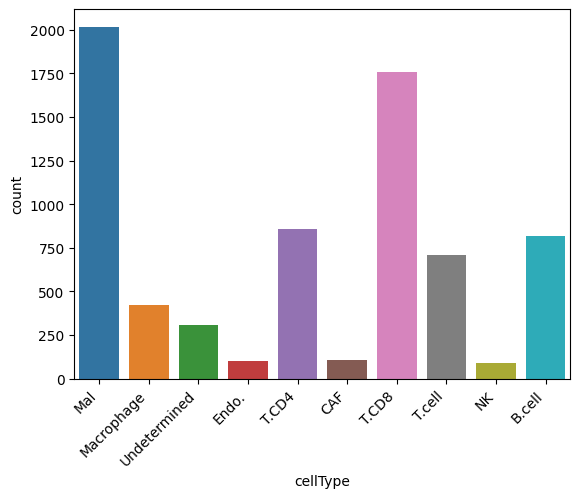

In [5]:
chart = sns.countplot(x = 'cellType', data=data, orient='v')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

### Encode Output Class

In [6]:
cellTypes = data["cellType"].unique()
class2idx = {cellTypes[i]:i for i in range(len(cellTypes))}
idx2class = {v: k for k, v in class2idx.items()}
data['cellType'].replace(class2idx, inplace=True)

### Create Input and Output Data

In [54]:
X = data.iloc[:, 2:] # Input features
y = data.iloc[:, 1]  # Output target

In [55]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

### Generate Dataset

In [33]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

### Weighted Sampling

In [47]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)

Define class weights as the reciprocal of each class count

In [45]:
class_count = torch.bincount(target_list)
class_weights = 1./class_count
class_weights

tensor([0.0007, 0.0033, 0.0045, 0.0133, 0.0016, 0.0130, 0.0008, 0.0020, 0.0149,
        0.0017])

In [46]:
class_weights_all = class_weights[target_list]
class_weights_all

tensor([0.0007, 0.0016, 0.0020,  ..., 0.0008, 0.0008, 0.0007])

In [48]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

### Model Parameters

In [99]:
EPOCHS = 5
BATCH_SIZE = 16
LEARNING_RATE = 0.01
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 10

### DataLoaders

In [88]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

### Neural Net Architecture

In [89]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        self.bn_cont = nn.BatchNorm1d(num_feature, eps=1e-05, momentum=0.1, affine=True)
        self.layers = nn.Sequential(
            nn.Linear(num_feature, 100, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True),
            nn.Linear(100, 100, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True),
            nn.Linear(100, num_class, bias=True)
        )

    def forward(self, x):
        x = self.bn_cont(x)
        x = self.layers(x)
        return x


Check if GPU is active

In [90]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Create model for our task

In [91]:
model = MulticlassClassification(NUM_FEATURES, NUM_CLASSES)
model.to(device)
model

MulticlassClassification(
  (bn_cont): BatchNorm1d(21590, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=21590, out_features=100, bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=100, out_features=100, bias=False)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)

Set an optimizer for gradient descent and a loss function

In [92]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Train model

Function to calculate accuracy each epoch

In [93]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [94]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [95]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.46173 | Val Loss: 1.90925 | Train Acc: 65.318| Val Acc: 59.652
Epoch 002: | Train Loss: 0.13437 | Val Loss: 2.90470 | Train Acc: 87.040| Val Acc: 58.783
Epoch 003: | Train Loss: 0.07296 | Val Loss: 2.90193 | Train Acc: 93.645| Val Acc: 63.826
Epoch 004: | Train Loss: 0.04375 | Val Loss: 4.04469 | Train Acc: 96.191| Val Acc: 58.609
Epoch 005: | Train Loss: 0.04668 | Val Loss: 4.27161 | Train Acc: 96.108| Val Acc: 65.565


### Test model

In [96]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<AxesSubplot: >

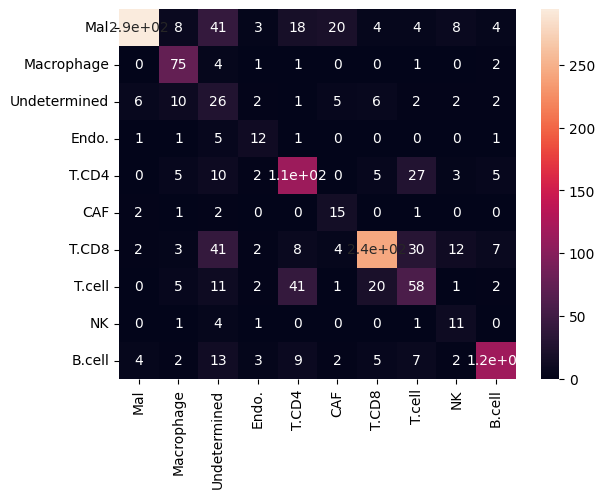

In [97]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

In [98]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.95      0.73      0.82       404
           1       0.68      0.89      0.77        84
           2       0.17      0.42      0.24        62
           3       0.43      0.57      0.49        21
           4       0.59      0.67      0.63       171
           5       0.32      0.71      0.44        21
           6       0.86      0.69      0.77       352
           7       0.44      0.41      0.43       141
           8       0.28      0.61      0.39        18
           9       0.84      0.71      0.77       164

    accuracy                           0.67      1438
   macro avg       0.56      0.64      0.57      1438
weighted avg       0.75      0.67      0.70      1438

